# Save pcigale fit results in a loop


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2024-02-08
- uddate : 2024-02-08

Find pcigale here https://cigale.lam.fr



- adaptation : Sylvie Dagoret-Campagne from  https://cigale.lam.fr


In [1]:
#%pylab widget
#import matplotlib.pyplot as plt
#matplotlib.rcParams['figure.figsize'] = [9.,6.]

In [2]:
#%pylab widget
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import ListedColormap

import matplotlib.gridspec as gridspec

plt.rcParams['figure.figsize'] = [12.,6.]
import seaborn as sns
import h5py

In [3]:
#bwr_map = plt.get_cmap('bwr')
#reversed_map = bwr_map.reversed() 
#cNorm = colors.Normalize(0., vmax=1.)
#scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=bwr_map)
#all_colors = scalarMap.to_rgba(df["zobs"].values, alpha=1)


In [4]:
import numpy as np

from IPython.display import display
from ipywidgets import widgets
from matplotlib import pyplot as plt

from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from astropy import constants as ctes 
from scipy.constants import c

from pcigale import sed
from pcigale import sed_modules as modules
from pcigale.warehouse import SedWarehouse
from pcigale.data import SimpleDatabase
import os,re

## Configuration

### Path where pcigale output results are

In [5]:
path = "20240205_181701_out"

### Date of the run

In [6]:
date = "2024-02-05"

### Output file

In [7]:
output_file_h5  = f"FittedSSPspectraPcigale_{date}.hdf5"

## Initialisation

In [8]:
def get_fitresults_dict(the_path):
    """
    paramters:
     - path : path where pcigale write results
    """
    all_files_runpcigale = sorted(os.listdir(the_path))
    spec_dict = {}
    for idx,filename in enumerate(all_files_runpcigale):

        # skip all file that are not ended by fits
        if not re.search('.*[.]fits$',filename):
            continue

        # 1) decode the spec number
        str_spec_found = re.findall('(^SPEC.+?)_.*', filename)
        #print("\t", idx," ",filename," ", str_spec_found)
        if len( str_spec_found) == 0:
            print(f"Skip filename {filename}")
            continue
        str_spec_found = str_spec_found[0]
  

        if str_spec_found in spec_dict.keys():
            #print("Found in dict ", spec_dict[str_spec_found])
            pass
        else:
            #print(f" ! {str_spec_found} NOT found in dict ")
            spec_dict[str_spec_found] = {"best_model": None,"SFH":None}

        d = spec_dict[str_spec_found]
    
        # 2) decode thefilename
        str_file_found = re.findall('^SPEC.+_(.*)[.]fits$', filename)[0]
        #print(idx,filename,str_file_found)

        if str_file_found == "SFH":
            d["SFH"] = filename
        elif str_file_found == "model":
            d["best_model"] = filename

        spec_dict[str_spec_found] = d
        
    return spec_dict
               
    

## Input

### Dictionary of file

In [9]:
spec_dict = get_fitresults_dict(path)

Skip filename observations.fits
Skip filename results.fits


### Select spectrum

In [10]:
index = 10
spec_name = list(spec_dict.keys())[index]
spec_name

'SPEC117'

In [11]:
spec_dict[spec_name]

{'best_model': 'SPEC117_best_model.fits', 'SFH': 'SPEC117_SFH.fits'}

In [12]:
file_best_model = os.path.join(path,spec_dict[spec_name]['best_model'])
file_sfh = os.path.join(path,spec_dict[spec_name]['SFH'])

In [13]:
t_best = Table.read(file_best_model)
t_sfh = Table.read(file_sfh)

In [14]:
t_best[:50]

wavelength,Fnu,L_lambda_total,stellar.old,stellar.young,nebular.absorption_old,nebular.absorption_young,nebular.lines_old,nebular.lines_young,nebular.continuum_old,nebular.continuum_young,attenuation.stellar.old,attenuation.stellar.young,attenuation.nebular.lines_old,attenuation.nebular.lines_young,attenuation.nebular.continuum_old,attenuation.nebular.continuum_young,dust,igm
nm,mJy,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13.175889999999999,2.101529514435313e-09,2.6960239702925726e+30,3.2889673621048796e+30,2.112864184690783e+30,-1.6444836810524398e+30,-1.0564320923453915e+30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.89180310525956e+27
13.61026,2.6564775189585478e-09,3.193901202044958e+30,3.488930084428768e+30,2.911545079319271e+30,-1.744465042214384e+30,-1.4557725396596356e+30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.336379829062748e+27
13.899840000000001,3.0863102478289126e-09,3.5576904246099563e+30,3.560440549399484e+30,3.5698987923987216e+30,-1.780220274699742e+30,-1.7849493961993608e+30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.479246289147339e+27
14.18942,8.203966013065921e-09,9.074918663489288e+30,6.060758899019519e+30,1.212946294082785e+31,-3.0303794495097593e+30,-6.064731470413925e+30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0192256434398373e+28
14.479,1.9198930696936677e-08,2.039614454130444e+31,1.1273231526634653e+31,2.961501442374598e+31,-5.636615763317326e+30,-1.480750721187299e+31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.797843388587782e+28
14.768580000000002,2.1429494957383564e-08,2.1881779250617656e+31,1.1621706675797708e+31,3.225056687123574e+31,-5.810853337898854e+30,-1.612528343561787e+31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.435752289906541e+28
15.05816,2.213178488455036e-08,2.173806093570999e+31,1.1467560266278924e+31,3.212249435964649e+31,-5.733780133139462e+30,-1.6061247179823244e+31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.696637725271489e+28
15.347740000000002,2.378084672966608e-08,2.248467545963037e+31,1.1572545980802227e+31,3.3520997173173144e+31,-5.786272990401114e+30,-1.6760498586586572e+31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.209611735731693e+28


In [15]:
list(t_best.columns)

['wavelength',
 'Fnu',
 'L_lambda_total',
 'stellar.old',
 'stellar.young',
 'nebular.absorption_old',
 'nebular.absorption_young',
 'nebular.lines_old',
 'nebular.lines_young',
 'nebular.continuum_old',
 'nebular.continuum_young',
 'attenuation.stellar.old',
 'attenuation.stellar.young',
 'attenuation.nebular.lines_old',
 'attenuation.nebular.lines_young',
 'attenuation.nebular.continuum_old',
 'attenuation.nebular.continuum_young',
 'dust',
 'igm']

## Read all results

In [16]:
t_res = Table.read(os.path.join(path,'results.fits'))

In [17]:
t_res[:4]

id,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,bayes.sfh.sfr100Myrs_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.galex.FUV,bayes.galex.FUV_err,bayes.galex.NUV,bayes.galex.NUV_err,bayes.sdss.gp,bayes.sdss.gp_err,bayes.sdss.ip,bayes.sdss.ip_err,bayes.sdss.rp,bayes.sdss.rp_err,bayes.sdss.up,bayes.sdss.up_err,bayes.vista.vircam.H,bayes.vista.vircam.H_err,bayes.vista.vircam.J,bayes.vista.vircam.J_err,bayes.vista.vircam.Ks,bayes.vista.vircam.Ks_err,bayes.vista.vircam.Y,bayes.vista.vircam.Y_err,bayes.vista.vircam.Z,bayes.vista.vircam.Z_err,best.chi_square,best.reduced_chi_square,best.agn.fracAGN_dale2014,best.attenuation.B_B90,best.attenuation.E_BV_factor,best.attenuation.E_BV_lines,best.attenuation.E_BVs,best.attenuation.FUV,best.attenuation.V_B90,best.attenuation.powerlaw_slope,best.attenuation.uv_bump_amplitude,best.attenuation.uv_bump_wavelength,best.attenuation.uv_bump_width,best.dust.alpha,best.nebular.f_dust,best.nebular.f_esc,best.nebular.lines_width,best.nebular.logU,best.nebular.ne,best.nebular.zgas,best.param.EW(500.7/1.0),best.param.EW(656.3/1.0),best.param.restframe_FUV-NUV,best.param.restframe_NUV-r_prime,best.sfh.age,best.sfh.age_burst,best.sfh.age_main,best.sfh.f_burst,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.metallicity,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.dust.luminosity,best.param.restframe_Lnu(FUV),best.param.restframe_Lnu(V_B90),best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.stellar.lum,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.lum_old,best.stellar.lum_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.galex.FUV,best.galex.NUV,best.sdss.up,best.sdss.gp,best.sdss.rp,best.sdss.ip,best.vista.vircam.Z,best.vista.vircam.Y,best.vista.vircam.J,best.vista.vircam.H,best.vista.vircam.Ks
,solMass / yr,solMass / yr,solMass / yr,solMass / yr,solMass / yr,solMass / yr,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,,,,mag,,mag,mag,mag,mag,,,nm,nm,,,,km / s,,1 / cm3,,nm,nm,mag,mag,Myr,Myr,Myr,,Myr,Myr,Myr,,,Myr,Myr,m,,W,W / Hz,W / Hz,solMass,solMass / yr,solMass / yr,solMass / yr,W,W,W,W,W,W,solMass,solMass,solMass,solMass,solMass,solMass,ph / s,ph / s,ph / s,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy
bytes7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
SPEC2,2.690478051334213,0.13452390256671065,2.7306441667975,0.136532208339875,2.6941116254730453,0.13470558127365226,0.0012892816551357742,1.4529673845824113e-07,0.002094805021122464,1.8696412446796292e-07,0.0039717213021012365,6.371424773760015e-07,0.012850990311673388,4.608342572288812e-06,0.009499652132380684,3.6978021497132776e-06,0.002668790520240912,5.869741482106958e-07,0.04194658852328467,5.272983069708891e-05,0.02972901209233811,1.431826882052124e-05,0.05321737326562015,7.616095605928444e-05,0.020362735770203262,1.7386491140926047e-06,0.016095554880481845,4.199553401553351e-06,58.31252776201896,6.47916975133544,0.0,0.668486572794879

### Selection 

In [18]:
cut_select = t_res["id"] == spec_name

In [19]:
t_res_sel = t_res[cut_select]
t_res_sel

id,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,bayes.sfh.sfr100Myrs_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.galex.FUV,bayes.galex.FUV_err,bayes.galex.NUV,bayes.galex.NUV_err,bayes.sdss.gp,bayes.sdss.gp_err,bayes.sdss.ip,bayes.sdss.ip_err,bayes.sdss.rp,bayes.sdss.rp_err,bayes.sdss.up,bayes.sdss.up_err,bayes.vista.vircam.H,bayes.vista.vircam.H_err,bayes.vista.vircam.J,bayes.vista.vircam.J_err,bayes.vista.vircam.Ks,bayes.vista.vircam.Ks_err,bayes.vista.vircam.Y,bayes.vista.vircam.Y_err,bayes.vista.vircam.Z,bayes.vista.vircam.Z_err,best.chi_square,best.reduced_chi_square,best.agn.fracAGN_dale2014,best.attenuation.B_B90,best.attenuation.E_BV_factor,best.attenuation.E_BV_lines,best.attenuation.E_BVs,best.attenuation.FUV,best.attenuation.V_B90,best.attenuation.powerlaw_slope,best.attenuation.uv_bump_amplitude,best.attenuation.uv_bump_wavelength,best.attenuation.uv_bump_width,best.dust.alpha,best.nebular.f_dust,best.nebular.f_esc,best.nebular.lines_width,best.nebular.logU,best.nebular.ne,best.nebular.zgas,best.param.EW(500.7/1.0),best.param.EW(656.3/1.0),best.param.restframe_FUV-NUV,best.param.restframe_NUV-r_prime,best.sfh.age,best.sfh.age_burst,best.sfh.age_main,best.sfh.f_burst,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.metallicity,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.dust.luminosity,best.param.restframe_Lnu(FUV),best.param.restframe_Lnu(V_B90),best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.stellar.lum,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.lum_old,best.stellar.lum_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.galex.FUV,best.galex.NUV,best.sdss.up,best.sdss.gp,best.sdss.rp,best.sdss.ip,best.vista.vircam.Z,best.vista.vircam.Y,best.vista.vircam.J,best.vista.vircam.H,best.vista.vircam.Ks
,solMass / yr,solMass / yr,solMass / yr,solMass / yr,solMass / yr,solMass / yr,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,,,,mag,,mag,mag,mag,mag,,,nm,nm,,,,km / s,,1 / cm3,,nm,nm,mag,mag,Myr,Myr,Myr,,Myr,Myr,Myr,,,Myr,Myr,m,,W,W / Hz,W / Hz,solMass,solMass / yr,solMass / yr,solMass / yr,W,W,W,W,W,W,solMass,solMass,solMass,solMass,solMass,solMass,ph / s,ph / s,ph / s,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy
bytes7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
SPEC117,2.6042704299655646,0.13021352149827822,2.643149552854432,0.13215747764272162,2.6077875780352775,0.13038937890176389,0.000612234573312386,1.165110921534855e-05,0.0011464649704874927,5.284910951758324e-06,0.00195601471864365,1.373235064503088e-05,0.006667809423024289,0.00024386762538301815,0.004723678822402665,0.0001725334708240807,0.0014684507739116497,2.3456393573915182e-05,0.021886271755327327,0.0018048866371605107,0.014645559410582962,0.0001569191712604835,0.02621224480853155,0.002417780183504364,0.010376511777459374,0.00025105932223692365,0.008675363883816664,0.00023597496498204229,11.652503070033331,1.2947225633370367,0.0,0.66848

In [20]:
t_res_sel["best.reduced_chi_square"][0]

1.2947225633370367

### Read data

In [21]:
file_data = os.path.join(path,"observations.fits")
FORS2= Table.read(file_data)
FORS2.add_index('id')

In [22]:
FORS2[:4]

id,redshift,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,sdss.up,sdss.up_err,sdss.gp,sdss.gp_err,sdss.rp,sdss.rp_err,sdss.ip,sdss.ip_err,vista.vircam.Z,vista.vircam.Z_err,vista.vircam.Y,vista.vircam.Y_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err
bytes7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
SPEC2,0.3456,0.024597,0.006225,0.012646,0.003231,--,--,0.002635,0.000305,0.008550,0.000870,0.014536,0.001549,0.020464,0.002152,0.025612,0.002879,0.032969,0.003465,0.047182,0.005195,0.064763,0.006954
SPEC3,0.6866,--,--,0.004906,0.002192,0.001665,0.000480,0.002418,0.000285,0.006525,0.000672,0.012610,0.001368,0.018209,0.001939,0.021529,0.002517,0.033779,0.003540,0.042549,0.004769,0.064977,0.006962
SPEC9,0.2927,--,--,0.009030,0.003131,--,--,0.001512,0.000198,0.005874,0.000603,0.008643,0.000986,0.011839,0.001369,0.011624,0.001687,0.016744,0.001943,0.021223,0.003000,0.022539,0.003158
SPEC13,0.6887,--,--,0.003222,0.001645,0.001036,0.000403,0.001298,0.000172,0.001864,0.000220,0.002078,0.000560,0.004230,0.000792,0.001636,0.001208,0.004766,0.001069,--,--,--,--


### Select

In [23]:
cut_fors2select = FORS2["id"] == spec_name

In [24]:
FORS2_sel = FORS2[cut_fors2select]

In [25]:
FORS2_sel["redshift"].value[0]

0.4479

### Filters

In [26]:
BANDS = [
    col for col in FORS2.colnames if not col.endswith("_err") 
    and not col.startswith("line") 
    and not col in ["id", "redshift", "distance"]
]

#with Database() as d:
#    BANDS_WAVE = np.array([d.get_filter(name).pivot_wavelength for name in BANDS])


with SimpleDatabase('filters') as d:
    #BANDS_WAVE = np.array([d.get(name).pivot_wavelength for name in BANDS])
    BANDS_WAVE = np.array([d.get(name=name).pivot for name in BANDS])
    

In [27]:
BANDS_best = [ "best." + bandname for bandname in BANDS]

In [28]:
band_sed_fluxes = np.array([ t_res_sel[bandname][0] for bandname in  BANDS_best])

# From pcigale

In [29]:
with SimpleDatabase('filters') as d:
    #BANDS_WAVE = np.array([d.get(name).pivot_wavelength for name in BANDS])
    BANDS_WAVE = np.array([d.get(name=name).pivot for name in BANDS])
    BANDS_NAME = BANDS
dict_filters = dict(zip(BANDS_NAME, BANDS_WAVE)) 

In [30]:
dict_filters 

{'galex.FUV': 153.50853059117946,
 'galex.NUV': 229.92449963384885,
 'sdss.up': 355.65239687948446,
 'sdss.gp': 470.2495279331732,
 'sdss.rp': 617.5578881059803,
 'sdss.ip': 748.9976846298566,
 'vista.vircam.Z': 876.6251399925129,
 'vista.vircam.Y': 1020.9939367474136,
 'vista.vircam.J': 1252.4338849656478,
 'vista.vircam.H': 1643.1277259087526,
 'vista.vircam.Ks': 2152.1001644008657}

In [31]:
#obs= FORS2_sel.to_pandas().to_dict()
obs = FORS2_sel
obs

id,redshift,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,sdss.up,sdss.up_err,sdss.gp,sdss.gp_err,sdss.rp,sdss.rp_err,sdss.ip,sdss.ip_err,vista.vircam.Z,vista.vircam.Z_err,vista.vircam.Y,vista.vircam.Y_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err
bytes7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
SPEC117,0.4479,--,--,0.003292,0.001642,0.000855,0.000397,0.001612,0.000199,0.004711,0.000487,0.006625,0.000859,0.010211,0.001234,0.011437,0.001695,0.017230,0.001994,0.023943,0.003200,0.024894,0.003404


In [32]:
series = ["model" ,"stellar_attenuated","stellar_unattenuated","nebular","dust"]

In [33]:
def plots_frompcigale(t_best_model, mod,obs, filters , series ,sed_type = "mJy", xrange = [10.*1e-3,5e4*1e-3],yrange = [False,False]):
    """

    parameters :
       t_best_model : Table of best fitted model (wrt wavelength)
       mod : Table of all fit result (line selected for the current spectrum)
       obs : Table of observed flux (in mJy)
       filters: dictionnary of filtername and pivot wavelength
       series : what to plot
       sed_type : mJy  Fnu in obs frame, lum : Llambda in restframe
       xrange : wavelength ranage in microns xrange = [100.*1e-3,1e4*1e-3]
    
    Need to convert flux density in mJy (mW/m2/Hz) into Luminosity W/nm and vice versa

    Fnu = 1/(4piDL^2) * lambda^2/c * L_lambda
    L_lambda = (4piDL^2) * (c/lambda^2) * F_nu

    No K correction is calculated
    
    """

    np.seterr(invalid="ignore")

    if True:
        # get the table containning all seds (wrt wavelength)
        sed = t_best_model
        # the best model
        # wavelengths from nm to microns 
        wavelength_spec = sed["wavelength"].data * 1e-3
        
        # pivot wavelengths in filter from nm to microns
        filters_wl = (np.array([filt_wl for filt_wl in filters.values()]) * 1e-3)

        
        # retrieve observed fluxes (in mJy)
        obs_fluxes = np.array([obs[filt].data[0] for filt in filters.keys()])
        obs_fluxes_err = np.array([obs[filt + "_err"].data[0] for filt in filters.keys()])
        
        # retrieve the model fluxes (in mJy)
        mod_fluxes = np.array(
            [
                mod["best." + filt].data[0]
                if "best." + filt in mod.colnames
                else np.nan
                for filt in filters.keys()
            ])

        # retrieve the redshift from the observation
        if obs["redshift"].data[0] >= 0:
            z = float(obs["redshift"].data[0])
        else:  # Redshift mode
            z = float(mod["best.universe.redshift"].data[0])

        # the redshift factor   
        zp1 = 1.0 + z

        # surface of the sphere centered on the object of radius distance-luminosity
        surf = 4.0 * np.pi * mod["best.universe.luminosity_distance"].data[0] ** 2

        # define the range if wavelength (in microns)
        xmin = 0.9 * np.min(filters_wl) if xrange[0] is False else xrange[0]
        xmax = 1.1 * np.max(filters_wl) if xrange[1] is False else xrange[1]

        if sed_type == "lum":
            # L_lambda = (4piDL^2) * (c/lambda^2) * F_nu
            # 1 mJy = 10^-29 W/m2/Hz
            # Every values converted to SI 
            # Convert wavelength from microns to meters
            # need to convert lumi from W/m to W/nm 
            k_corr_SED = (1e-29 * surf * ctes.c.value/ (filters_wl * 1e-6)**2)*1e-9

            #print("k_corr_SED --> W/m2 = ",k_corr_SED)
            
            # convert fluxes from mJy to W/nm
            obs_fluxes *= k_corr_SED
            obs_fluxes_err *= k_corr_SED
            mod_fluxes *= k_corr_SED

            #for cname in sed.colnames[1:]:

            # I think this should not be applied (why 1e3)
            for cname in sed.colnames[2:]:
                #sed[cname] *= wavelength_spec * 1e3
                sed[cname] *=  1e0
                
            # set source rest frame
            filters_wl /= zp1
            wavelength_spec /= zp1
            xmin /= zp1
            xmax /= zp1
            
        elif sed_type == "mJy":
            k_corr_SED = 1.0
            # 1 W/m2/Hz = 10^29 mJy
            #Fnu = 1/(4piDL^2) * lambda^2/c * L_lambda
            fact = 1e29 * 1e-3 * wavelength_spec ** 2 / ctes.c.value / surf

            #print("fact --> mJy = ",fact)
            
            #for cname in sed.colnames[1:]:
            for cname in sed.colnames[2:]:
                sed[cname] *= fact
        else:
            print("ERROR Unknown plot type.")

        wsed = np.where((wavelength_spec > xmin) & (wavelength_spec < xmax))
       

        
        print("================ START the figure ================================================================")

        #series = ["model" ,"stellar_attenuated","stellar_unattenuated","nebular","dust"]

        #'wavelength',
        # 'Fnu',
        # 'L_lambda_total',
        # 'stellar.old',
        # 'stellar.young',
        # 'nebular.absorption_old',
        # 'nebular.absorption_young',
        # 'nebular.lines_old',
        # 'nebular.lines_young',
        # 'nebular.continuum_old',
        # 'nebular.continuum_young',
        # 'attenuation.stellar.old',
        # 'attenuation.stellar.young',
        # 'attenuation.nebular.lines_old',
        # 'attenuation.nebular.lines_young',
        # 'attenuation.nebular.continuum_old',
        # 'attenuation.nebular.continuum_young',
        # 'dust',
        # 'igm'


        figure = plt.figure()
        gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
        
        #if (sed.columns[1][wsed] > 0.0).any():
        if (sed.columns[0][wsed].data > 0.0).any():    
            
            ax1 = plt.subplot(gs[0])
            ax2 = plt.subplot(gs[1])

            # Stellar emission
            if ( "stellar_attenuated" in series and "stellar.young" in sed.columns):
                spectrum =  sed["stellar.young"].data[wsed]  + sed["stellar.old"].data[wsed]

                if "nebular.absorption_young" in sed.columns:
                    spectrum += sed["nebular.absorption_young"].data[wsed]
                    spectrum += sed["nebular.absorption_old"].data[wsed]

                if "attenuation.stellar.young" in sed.columns:
                    spectrum += sed["attenuation.stellar.young"].data[wsed]
                    spectrum += sed["attenuation.stellar.old"].data[wsed]

                ax1.loglog(
                        wavelength_spec[wsed],
                        spectrum,
                        label="Stellar attenuated",
                        color="gold",
                        marker=None,
                        nonpositive="clip",
                        linestyle="-",
                        linewidth=1.0,
                    )
                #print("stellar_attenuated spectrum \t",spectrum)

            if ("stellar_unattenuated" in series and "stellar.young" in sed.columns):

                spectrum = sed["stellar.old"].data[wsed] + sed["stellar.young"].data[wsed]
                
                ax1.loglog(
                        wavelength_spec[wsed],
                        spectrum,
                        label="Stellar unattenuated",
                        color="xkcd:deep sky blue",
                        marker=None,
                        nonpositive="clip",
                        linestyle="--",
                        linewidth=1.0,
                    )
                #print("stellar_unattenuated spectrum \t",spectrum)

            # Nebular emission
            if "nebular" in series and "nebular.lines_young" in sed.columns:
                spectrum = (
                        sed["nebular.lines_young"].data[wsed]
                        + sed["nebular.lines_old"].data[wsed]
                        + sed["nebular.continuum_young"].data[wsed]
                        + sed["nebular.continuum_old"].data[wsed]
                    )

                if "attenuation.nebular.lines_young" in sed.columns:
                        spectrum += sed["attenuation.nebular.lines_young"].data[wsed]
                        spectrum += sed["attenuation.nebular.lines_old"].data[wsed]
                        spectrum += sed["attenuation.nebular.continuum_young"].data[wsed]
                        spectrum += sed["attenuation.nebular.continuum_old"].data[wsed]

                ax1.loglog(
                        wavelength_spec[wsed],
                        spectrum,
                        label="Nebular emission",
                        color="xkcd:true green",
                        marker=None,
                        nonpositive="clip",
                        linewidth=1.0,
                    )
                #print("nebular  spectrum \t",spectrum)

            # Dust emission Draine & Li
            if "dust" in series and "dust.Umin_Umin" in sed.columns:
                spectrum =  sed["dust.Umin_Umin"].data[wsed] + sed["dust.Umin_Umax"].data[wsed]
                ax1.loglog(
                        wavelength_spec[wsed],spectrum,
                        label="Dust emission",
                        color="xkcd:bright red",
                        marker=None,
                        nonpositive="clip",
                        linestyle="-",
                        linewidth=1.0,
                    )
                #print("Dust Draine Li  spectrum \t",spectrum)

            # Dust emission Dale
            if "dust" in series and "dust" in sed.columns:
                spectrum = sed["dust"].data[wsed]
                ax1.loglog(
                        wavelength_spec[wsed],
                        spectrum,
                        label="Dust emission",
                        color="xkcd:bright red",
                        marker=None,
                        nonpositive="clip",
                        linestyle="-",
                        linewidth=1.0,
                    )
                #print("Dust spectrum \t",spectrum)

            # AGN emission
            if "agn" in series and ( "agn.fritz2006_torus" in sed.columns or "agn.SKIRTOR2016_torus" in sed.columns):
                if "agn.fritz2006_torus" in sed.columns:
                    agn_sed = (
                            sed["agn.fritz2006_polar_dust"]
                            + sed["agn.fritz2006_torus"]
                            + sed["agn.fritz2006_disk"]
                        )
                elif "agn.SKIRTOR2016_torus" in sed.columns:
                    agn_sed = (
                            sed["agn.SKIRTOR2016_polar_dust"]
                            + sed["agn.SKIRTOR2016_torus"]
                            + sed["agn.SKIRTOR2016_disk"]
                        )
                if "xray.agn" in sed.columns:
                    agn_sed += sed["xray.agn"]
                if "radio.agn" in sed.columns:
                    agn_sed += sed["radio.agn"]
                    
                ax1.loglog(
                        wavelength_spec[wsed],
                        agn_sed[wsed],
                        label="AGN emission",
                        color="xkcd:apricot",
                        marker=None,
                        nonpositive="clip",
                        linestyle="-",
                        linewidth=1.0,
                    )

            # Radio emission
            if "radio" in series and "radio.sf_nonthermal" in sed.columns:
                ax1.loglog(
                        wavelength_spec[wsed],
                        sed["radio.sf_nonthermal"][wsed],
                        label="Radio SF nonthermal",
                        color="brown",
                        marker=None,
                        nonpositive="clip",
                        linestyle="-",
                        linewidth=1.0,
                    )

            if "model" in series:
                ax1.loglog(
                        wavelength_spec[wsed],
                        sed["L_lambda_total"].data[wsed],
                        label="Model spectrum",
                        color="k",
                        nonpositive="clip",
                        linestyle="-",
                        linewidth=1.5,
                    )
                #print("model", sed["L_lambda_total"].data[wsed])

            
            ax1.set_autoscale_on(False)
            
            s = np.argsort(filters_wl)
            filters_wl = filters_wl[s]
            mod_fluxes = mod_fluxes[s]
            obs_fluxes = obs_fluxes[s]
            obs_fluxes_err = obs_fluxes_err[s]
            ax1.scatter(
                    filters_wl,
                    mod_fluxes,
                    marker="o",
                    color="xkcd:strawberry",
                    s=8,
                    zorder=3,
                    label="Model fluxes",
                )
            mask_ok = np.logical_and(obs_fluxes > 0.0, obs_fluxes_err > 0.0)
            ax1.errorbar(
                    filters_wl[mask_ok],
                    obs_fluxes[mask_ok],
                    yerr=obs_fluxes_err[mask_ok],
                    ls="",
                    marker="o",
                    label="Observed fluxes",
                    markerfacecolor="None",
                    markersize=5,
                    markeredgecolor="xkcd:pastel purple",
                    color="xkcd:light indigo",
                    capsize=0.0,
                    zorder=3,
                    lw=1,
                )
            mask_uplim = np.logical_and(
                    np.logical_and(obs_fluxes > 0.0, obs_fluxes_err < 0.0),
                    obs_fluxes_err > -9990.0 * k_corr_SED,
                )
            if not mask_uplim.any() == False:
                ax1.errorbar(
                        filters_wl[mask_uplim],
                        obs_fluxes[mask_uplim],
                        yerr=obs_fluxes_err[mask_uplim],
                        ls="",
                        marker="v",
                        label="Observed upper limits",
                        markerfacecolor="None",
                        markersize=6,
                        markeredgecolor="g",
                        capsize=0.0,
                    )
            mask_noerr = np.logical_and( obs_fluxes > 0.0, obs_fluxes_err < -9990.0 * k_corr_SED)
            if not mask_noerr.any() == False:
                ax1.errorbar(
                        filters_wl[mask_noerr],
                        obs_fluxes[mask_noerr],
                        ls="",
                        marker="p",
                        markerfacecolor="None",
                        markersize=5,
                        markeredgecolor="r",
                        label="Observed fluxes, no errors",
                        capsize=0.0,
                    )

            # Work with residuals
            mask = np.where(obs_fluxes > 0.0)
            ax2.errorbar(
                    filters_wl[mask],
                    (obs_fluxes[mask] - mod_fluxes[mask]) / obs_fluxes[mask],
                    yerr=obs_fluxes_err[mask] / obs_fluxes[mask],
                    marker="_",
                    label="(Obs-Mod)/Obs",
                    color="k",
                    capsize=0.0,
                    ls="None",
                    lw=1,
                )
            ax2.plot([xmin, xmax], [0.0, 0.0], ls="--", color="k")
            ax2.set_xscale("log")
            ax2.minorticks_on()

            ax1.tick_params(
                    direction="in",
                    axis="both",
                    which="both",
                    top=True,
                    left=True,
                    right=True,
                    bottom=False,
                )
            ax2.tick_params(direction="in", axis="both", which="both", right=True)

            figure.subplots_adjust(hspace=0.0, wspace=0.0)

            ax1.set_xlim(xmin, xmax)

            if yrange[0] is not False:
                ymin = yrange[0]
            else:
                if not mask_uplim.any() == False:
                    ymin = min(
                            min(
                                np.min(obs_fluxes[mask_ok]),
                                np.min(obs_fluxes[mask_uplim]),
                            ),
                            min(
                                np.min(mod_fluxes[mask_ok]),
                                np.min(mod_fluxes[mask_uplim]),
                            ),
                        )
                elif not mask_ok.any() == False:
                    ymin = min(
                            np.min(obs_fluxes[mask_ok]),
                            np.min(mod_fluxes[mask_ok]),
                        )
                else:  # No valid flux (e.g., fitting only properties)
                    ymin = ax1.get_ylim()[0]
                ymin *= 1e-2

            if yrange[1] is not False:
                ymax = yrange[1]
            else:
                if not mask_uplim.any() == False:
                    ymax = max(
                            max(
                                np.max(obs_fluxes[mask_ok]),
                                np.max(obs_fluxes[mask_uplim]),
                            ),
                            max(
                                np.max(mod_fluxes[mask_ok]),
                                np.max(mod_fluxes[mask_uplim]),
                            ),
                        )
                elif not mask_ok.any() == False:
                    ymax = max(
                            np.max(obs_fluxes[mask_ok]),
                            np.max(mod_fluxes[mask_ok]),
                        )
                else:  # No valid flux (e.g., fitting only properties)
                    ymax = ax1.get_ylim()[1]
                ymax *= 1e2

            xmin = xmin if xmin < xmax else xmax - 1e1
            ymin = ymin if ymin < ymax else ymax - 1e1

            ax1.set_ylim(ymin, ymax)
            ax2.set_xlim(xmin, xmax)
            ax2.set_ylim(-1.0, 1.0)
            
            if sed_type == "lum":
                ax2.set_xlabel(r"Rest-frame wavelength [$\mu$m]")
                ax1.set_ylabel("Luminosity [W/nm]")
            else:
                ax2.set_xlabel(r"Observed $\lambda$ ($\mu$m)")
                ax1.set_ylabel(r"S$_\nu$ (mJy)")
                
            ax2.set_ylabel("Relative\nresidual")
            ax1.legend(fontsize=6, loc="best", frameon=False)
            ax2.legend(fontsize=6, loc="best", frameon=False)
            plt.setp(ax1.get_xticklabels(), visible=False)
            plt.setp(ax1.get_yticklabels()[1], visible=False)
            figure.suptitle(
                    f"Best model for {obs['id'].data[0]}\n (z={z:.3}, "
                    f"reduced χ²={mod['best.reduced_chi_square'].data[0]:.2})"
                )

            ax1.grid()
            ax2.grid()
        plt.show()
        #plt.close(figure)
      


In [34]:
def get_SSPfrompcigale(t_best_model, mod,obs, filters , series ,sed_type = "mJy", xrange = [10.*1e-3,5e4*1e-3],yrange = [False,False]):
    """

    parameters :
       t_best_model : Table of best fitted model (wrt wavelength)
       mod : Table of all fit result (line selected for the current spectrum)
       obs : Table of observed flux (in mJy)
       filters: dictionnary of filtername and pivot wavelength
       series : what to plot
       sed_type : mJy  Fnu in obs frame, lum : Llambda in restframe
       xrange : wavelength ranage in microns xrange = [100.*1e-3,1e4*1e-3]
    
    Need to convert flux density in mJy (mW/m2/Hz) into Luminosity W/nm and vice versa

    Fnu = 1/(4piDL^2) * lambda^2/c * L_lambda
    L_lambda = (4piDL^2) * (c/lambda^2) * F_nu

    No K correction is calculated
    
    """

    all_data = {}

    if True:
        # get the table containning all seds (wrt wavelength)
        sed = t_best_model
        # the best model
        # wavelengths from nm to microns 
        wavelength_spec = sed["wavelength"].data * 1e-3
        
        # pivot wavelengths in filter from nm to microns
        filters_wl = (np.array([filt_wl for filt_wl in filters.values()]) * 1e-3)

        
        # retrieve observed fluxes (in mJy)
        obs_fluxes = np.array([obs[filt].data[0] for filt in filters.keys()])
        obs_fluxes_err = np.array([obs[filt + "_err"].data[0] for filt in filters.keys()])
        
        # retrieve the model fluxes (in mJy)
        mod_fluxes = np.array(
            [
                mod["best." + filt].data[0]
                if "best." + filt in mod.colnames
                else np.nan
                for filt in filters.keys()
            ])

        # retrieve the redshift from the observation
        if obs["redshift"].data[0] >= 0:
            z = float(obs["redshift"].data[0])
        else:  # Redshift mode
            z = float(mod["best.universe.redshift"].data[0])

        # the redshift factor   
        zp1 = 1.0 + z

        # surface of the sphere centered on the object of radius distance-luminosity
        surf = 4.0 * np.pi * mod["best.universe.luminosity_distance"].data[0] ** 2

        # define the range if wavelength (in microns)
        xmin = 0.9 * np.min(filters_wl) if xrange[0] is False else xrange[0]
        xmax = 1.1 * np.max(filters_wl) if xrange[1] is False else xrange[1]

        if sed_type == "lum":
            # L_lambda = (4piDL^2) * (c/lambda^2) * F_nu
            # 1 mJy = 10^-29 W/m2/Hz
            # Every values converted to SI 
            # Convert wavelength from microns to meters
            # need to convert lumi from W/m to W/nm 
            k_corr_SED = (1e-29 * surf * ctes.c.value/ (filters_wl * 1e-6)**2)*1e-9

            #print("k_corr_SED --> W/m2 = ",k_corr_SED)
            
            # convert fluxes from mJy to W/nm
            obs_fluxes *= k_corr_SED
            obs_fluxes_err *= k_corr_SED
            mod_fluxes *= k_corr_SED

            #for cname in sed.colnames[1:]:

            # I think this should not be applied (why 1e3)
            for cname in sed.colnames[2:]:
                #sed[cname] *= wavelength_spec * 1e3
                sed[cname] *=  1e0
                
            # set source rest frame
            filters_wl /= zp1
            wavelength_spec /= zp1
            xmin /= zp1
            xmax /= zp1
            
        elif sed_type == "mJy":
            k_corr_SED = 1.0
            # 1 W/m2/Hz = 10^29 mJy
            #Fnu = 1/(4piDL^2) * lambda^2/c * L_lambda
            fact = 1e29 * 1e-3 * wavelength_spec ** 2 / ctes.c.value / surf

            #print("fact --> mJy = ",fact)
            
            #for cname in sed.colnames[1:]:
            for cname in sed.colnames[2:]:
                sed[cname] *= fact
        else:
            print("ERROR Unknown plot type.")

        wsed = np.where((wavelength_spec > xmin) & (wavelength_spec < xmax))

        # save wavelength
        all_data["wl"] = wavelength_spec
        
        if (sed.columns[0][wsed].data > 0.0).any():    
            
           
            # Stellar emission
            if ( "stellar_attenuated" in series and "stellar.young" in sed.columns):
                spectrum =  sed["stellar.young"].data  + sed["stellar.old"].data

                if "nebular.absorption_young" in sed.columns:
                    spectrum += sed["nebular.absorption_young"].data
                    spectrum += sed["nebular.absorption_old"].data

                if "attenuation.stellar.young" in sed.columns:
                    spectrum += sed["attenuation.stellar.young"].data
                    spectrum += sed["attenuation.stellar.old"].data
                    
                all_data["stellar_attenuated"] = spectrum

            if ("stellar_unattenuated" in series and "stellar.young" in sed.columns):

                spectrum = sed["stellar.old"].data + sed["stellar.young"].data
                all_data["stellar_unattenuated"] = spectrum

            # Nebular emission
            if "nebular" in series and "nebular.lines_young" in sed.columns:
                spectrum = (
                        sed["nebular.lines_young"].data
                        + sed["nebular.lines_old"].data
                        + sed["nebular.continuum_young"].data
                        + sed["nebular.continuum_old"].data
                    )

                if "attenuation.nebular.lines_young" in sed.columns:
                        spectrum += sed["attenuation.nebular.lines_young"].data
                        spectrum += sed["attenuation.nebular.lines_old"].data
                        spectrum += sed["attenuation.nebular.continuum_young"].data
                        spectrum += sed["attenuation.nebular.continuum_old"].data

               
                all_data["nebular_emission"] = spectrum

            # Dust emission Draine & Li
            if "dust" in series and "dust.Umin_Umin" in sed.columns:
                spectrum =  sed["dust.Umin_Umin"].data + sed["dust.Umin_Umax"].data
                all_data["dust_emission_draineli"] = spectrum
               

            # Dust emission Dale
            if "dust" in series and "dust" in sed.columns:
                spectrum = sed["dust"].data
                all_data["dust_emission_dale"] = spectrum
              

            # AGN emission
            if "agn" in series and ( "agn.fritz2006_torus" in sed.columns or "agn.SKIRTOR2016_torus" in sed.columns):
                if "agn.fritz2006_torus" in sed.columns:
                    agn_sed = (
                            sed["agn.fritz2006_polar_dust"]
                            + sed["agn.fritz2006_torus"]
                            + sed["agn.fritz2006_disk"]
                        )
                elif "agn.SKIRTOR2016_torus" in sed.columns:
                    agn_sed = (
                            sed["agn.SKIRTOR2016_polar_dust"]
                            + sed["agn.SKIRTOR2016_torus"]
                            + sed["agn.SKIRTOR2016_disk"]
                        )
                if "xray.agn" in sed.columns:
                    agn_sed += sed["xray.agn"]
                if "radio.agn" in sed.columns:
                    agn_sed += sed["radio.agn"]

                all_data["agn_sed"] = agn_sed
                

            # Radio emission
            if "radio" in series and "radio.sf_nonthermal" in sed.columns:
                all_data["radio_sf_nonthermal"] = sed["radio.sf_nonthermal"]
              
            if "model" in series:
                spectrum = sed["L_lambda_total"].data
                all_data["model"] = spectrum

    return all_data
                

## Table must be copied otherwise would be overwritten

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_77723/24951084.py:36: UserWarning: Warning: converting a masked element to nan.
  obs_fluxes = np.array([obs[filt].data[0] for filt in filters.keys()])
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_77723/24951084.py:37: UserWarning: Warning: converting a masked element to nan.
  obs_fluxes_err = np.array([obs[filt + "_err"].data[0] for filt in filters.keys()])


================ START the figure ================================================================


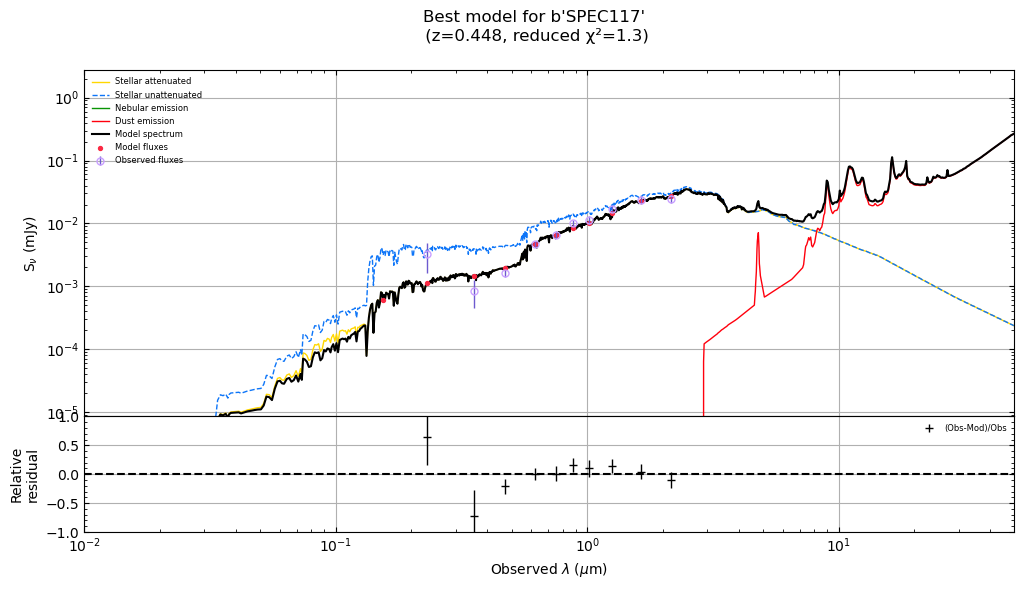

In [35]:
plots_frompcigale(t_best_model= t_best.copy(), mod = t_res_sel.copy(), obs= FORS2_sel.copy(), filters = dict_filters, series=series, 
                  sed_type = "mJy")

In [36]:
dict_FluxmJy = get_SSPfrompcigale(t_best_model= t_best.copy(), mod = t_res_sel.copy(), obs= FORS2_sel.copy(), filters = dict_filters, series=series, 
                  sed_type = "mJy")

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_77723/3355053614.py:36: UserWarning: Warning: converting a masked element to nan.
  obs_fluxes = np.array([obs[filt].data[0] for filt in filters.keys()])
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_77723/3355053614.py:37: UserWarning: Warning: converting a masked element to nan.
  obs_fluxes_err = np.array([obs[filt + "_err"].data[0] for filt in filters.keys()])


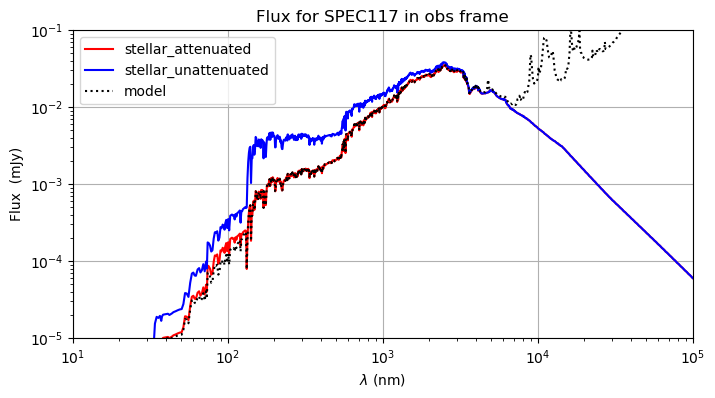

In [37]:
fig=plt.figure(figsize=(8,4))
plt.loglog(dict_FluxmJy['wl']*1000,dict_FluxmJy['stellar_attenuated'],'r-',label="stellar_attenuated")
plt.loglog(dict_FluxmJy['wl']*1000,dict_FluxmJy['stellar_unattenuated'],'b-',label="stellar_unattenuated")
plt.loglog(dict_FluxmJy['wl']*1000,dict_FluxmJy['model'],'k:',label="model")
plt.xlim(1e-2*1000,1e2*1000)
plt.ylim(1e-5,1e-1)
plt.title(f"Flux for {spec_name} in obs frame")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("Flux  (mJy)")
plt.grid()
plt.legend()

In [38]:
dict_Lum = get_SSPfrompcigale(t_best_model= t_best.copy(), mod = t_res_sel.copy(), obs= FORS2_sel.copy(), filters = dict_filters, series=series, 
                  sed_type = "lum")

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_77723/3355053614.py:36: UserWarning: Warning: converting a masked element to nan.
  obs_fluxes = np.array([obs[filt].data[0] for filt in filters.keys()])
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_77723/3355053614.py:37: UserWarning: Warning: converting a masked element to nan.
  obs_fluxes_err = np.array([obs[filt + "_err"].data[0] for filt in filters.keys()])


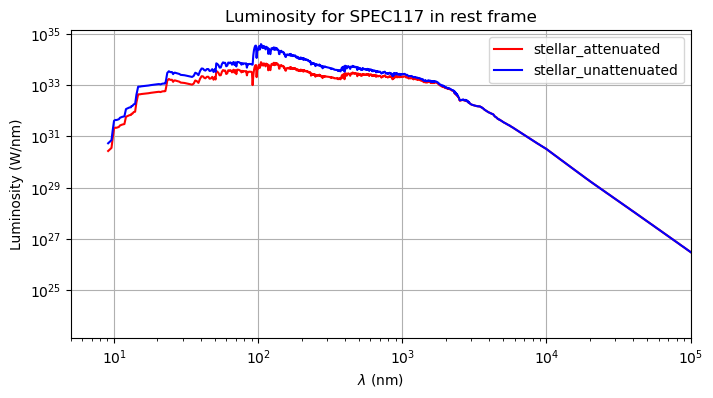

In [39]:
fig=plt.figure(figsize=(8,4))
plt.loglog(dict_Lum['wl']*1000,dict_Lum['stellar_attenuated'],'r-',label="stellar_attenuated")
plt.loglog(dict_Lum['wl']*1000,dict_Lum['stellar_unattenuated'],'b-',label="stellar_unattenuated")
#plt.loglog(dict_Lum['wl']*1000,dict_FluxmJy['model'],'k:',label="model")
plt.xlim(0.5e-2*1000,1e2*1000)
#plt.ylim(1e-5,1e-1)
plt.title(f"Luminosity for {spec_name} in rest frame")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("Luminosity (W/nm)")
plt.grid()
plt.legend()

## Loops

In [40]:
list_of_keys = np.array(list(spec_dict.keys())) 

In [41]:
all_nums = []
for key in list_of_keys:
    num_str = re.findall("^SPEC(.+)",key)[0]
    all_nums.append(int(num_str)) 
all_nums = np.array(all_nums)

In [42]:
sorted_indexes = np.argsort(all_nums)

In [43]:
list_of_keys_sorted = list_of_keys[np.argsort(all_nums)]

In [44]:
all_lum = []
all_flx = []

for spec_name in list_of_keys_sorted:

    # retrieve the filename
    file_best_model = os.path.join(path,spec_dict[spec_name]['best_model'])
    file_sfh = os.path.join(path,spec_dict[spec_name]['SFH'])

    # readthe table
    t_best = Table.read(file_best_model)
    t_sfh = Table.read(file_sfh)

    #get the result for that spectrum, t_res table table of all results outside this loop    
    cut_select = t_res["id"] == spec_name
    t_res_sel = t_res[cut_select]

    # data and select this spectrum row
    cut_fors2select = FORS2["id"] == spec_name
    FORS2_sel = FORS2[cut_fors2select]


    dict_FluxmJy = get_SSPfrompcigale(t_best_model= t_best.copy(), mod = t_res_sel.copy(), obs= FORS2_sel.copy(), filters = dict_filters, series=series, 
                  sed_type = "mJy")
    
    
    dict_Lum = get_SSPfrompcigale(t_best_model= t_best.copy(), mod = t_res_sel.copy(), obs= FORS2_sel.copy(), filters = dict_filters, series=series, 
                  sed_type = "lum")


    all_lum.append(dict_Lum)
    all_flx.append(dict_FluxmJy)
    

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_77723/3355053614.py:36: UserWarning: Warning: converting a masked element to nan.
  obs_fluxes = np.array([obs[filt].data[0] for filt in filters.keys()])
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_77723/3355053614.py:37: UserWarning: Warning: converting a masked element to nan.
  obs_fluxes_err = np.array([obs[filt + "_err"].data[0] for filt in filters.keys()])
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_77723/3355053614.py:40: UserWarning: Warning: converting a masked element to nan.
  mod_fluxes = np.array(


## Save file

### Create output file

In [49]:
hf_outfile =  h5py.File(output_file_h5, 'w') 

In [50]:
for idx,spec_name in enumerate(list_of_keys_sorted):

    # retrieve the filename
    file_best_model = os.path.join(path,spec_dict[spec_name]['best_model'])
    file_sfh = os.path.join(path,spec_dict[spec_name]['SFH'])

    # readthe table
    t_best = Table.read(file_best_model)
    t_sfh = Table.read(file_sfh)

    #get the result for that spectrum, t_res table table of all results outside this loop    
    cut_select = t_res["id"] == spec_name
    t_res_sel = t_res[cut_select]

    # data and select this spectrum row
    cut_fors2select = FORS2["id"] == spec_name
    FORS2_sel = FORS2[cut_fors2select]


    # decode the result of the fit
    chi2_red = t_res_sel["best.reduced_chi_square"][0]
    #redshift = t_res_sel["best.universe.redshift"][0]
    redshift = FORS2_sel["redshift"].value[0]
    
    dict_FluxmJy = all_flx[idx] 
    dict_Lum = all_lum[idx]

    # wavelength in nm
    wl = dict_FluxmJy["wl"]*100.
    flx_model = dict_FluxmJy["model"]
    flx_unatt = dict_FluxmJy["stellar_unattenuated"]
    flx_att = dict_FluxmJy["stellar_attenuated"]
    lum_unatt = dict_Lum["stellar_unattenuated"]
    lum_att = dict_Lum["stellar_attenuated"]
    
    # create the group
    h5group = hf_outfile.create_group(spec_name)


    
    h5group.attrs["redshift"] = redshift 
    h5group.attrs["chi2_red"] = chi2_red 
        

    d = h5group.create_dataset("wl",data=wl,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("flnu_model",data=flx_model,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("flnu_stelatt",data=flx_att,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("flnu_stelunatt",data=flx_unatt,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("lum_stelatt",data=lum_att,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("lum_stelunatt",data=lum_unatt,compression="gzip", compression_opts=9)
   



### Save output file

In [51]:
hf_outfile.close() 

## Read again the written file to check

In [58]:
import collections
from collections import OrderedDict
import re

In [59]:
input_file_h5  = output_file_h5 

In [60]:
if os.path.isfile(input_file_h5):
    hf = h5py.File(input_file_h5, 'r')
    list_of_groupkeys = list(hf.keys())
    # pick one key
    key_sel =  list_of_groupkeys[0]
    # pick one group
    group = hf.get(key_sel)
    #pickup all attribute names
    list_of_subgroup_keys = []
    for k in group.attrs.keys():
        list_of_subgroup_keys.append(k)
else:
    hf = None
    list_of_groupkeys = []
    list_of_subgroup_keys = []

In [61]:
print(list_of_groupkeys[:10])

['SPEC102', 'SPEC106', 'SPEC107', 'SPEC109', 'SPEC110', 'SPEC111', 'SPEC112', 'SPEC113', 'SPEC114', 'SPEC115']


In [62]:
list_of_subgroup_keys

['chi2_red', 'redshift']

In [64]:
groupname = list_of_groupkeys[0]

In [65]:
attr_dict = OrderedDict()
if groupname in list_of_groupkeys:
    group = hf.get(groupname)
    for nameval in list_of_subgroup_keys:
        attr_dict[nameval] = group.attrs[nameval]

In [66]:
attr_dict

OrderedDict([('chi2_red', 1.4191969512171358), ('redshift', 0.5133)])

In [67]:
group = hf.get(groupname)
wl = np.array(group.get("wl"))
flnu_model = np.array(group.get("flnu_model"))
flnu_stelatt = np.array(group.get("flnu_stelatt"))
flnu_stelunatt = np.array(group.get("flnu_stelunatt"))
lum_stelatt = np.array(group.get("lum_stelatt"))
lum_stelunatt = np.array(group.get("lum_stelunatt"))

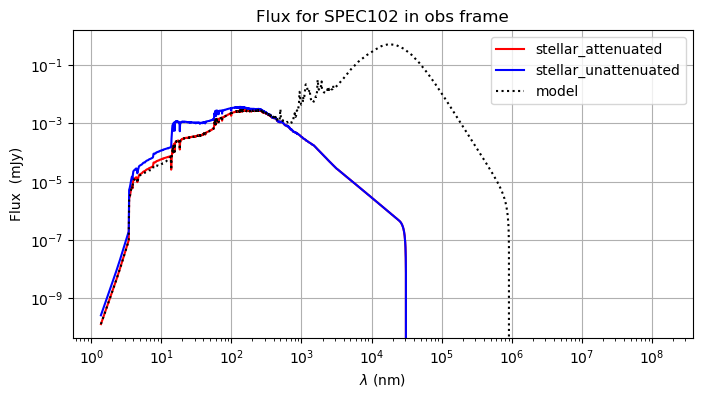

In [68]:
fig=plt.figure(figsize=(8,4))
plt.loglog(wl,flnu_stelatt,'r-',label="stellar_attenuated")
plt.loglog(wl,flnu_stelunatt,'b-',label="stellar_unattenuated")
plt.loglog(wl,flnu_model,'k:',label="model")

plt.title(f"Flux for {groupname} in obs frame")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("Flux  (mJy)")
plt.grid()
plt.legend()